In [1]:
import tensorflow as tf
import numpy as np
import os
from temprel.rdkit import smiles_to_fingerprint
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import seaborn as sns
import scipy
import hashlib
from tqdm import tqdm
%matplotlib inline


In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/en

In [2]:
!ls ../for\ GCP/

12Apr2021_v4
12May2021-bkms
12May2021-bkms.zip
13May2021-retro.templates.combined.json.gz
15Jun2021_bkms_traintestval
19Feb2020.retro.templates.combined.json.gz
22Mar2021_retro.templates.combined.json.gz
24May2021_bkms
24May2021_bkms.zip
25May2021_retro.templates.combined.json.gz
29Jun2021-retro.templates.combined.json.gz
29Jun2021_bkms_traintestval
29Jun2021_bkms_traintestval.zip
29Mar2021_reaxys_enzymatic
29Mar2021_reaxys_enzymatic.zip
30Mar2021_bkms.zip
30Mar2021_reaxys_enzymatic
30Mar2021_reaxys_enzymatic.zip
31Mar2021_bkms_neutral.zip
31Mar2021_retro.templates.combined.json.gz
5Apr2021_retro.templates.combined.json.gz
8Apr2021-bkms.zip
8Apr2021_retro.templates.combined.json.gz
9Apr2021-bkms
9Apr2021-bkms.zip
9Apr2021_v4-bkms
9Apr2021_v4-bkms.zip
9Apr2021_v4_retro.templates.combined.json.gz
9Jun2021_bkms_traintestval
9Jun2021_bkms_traintestval.zip
bkms.zip
bkms_model_all_data
bkms_model_all_data.zip
buyables.combined.json.gz


In [4]:
# Set figure defaults:

figure_dir = '/Users/Itai/Box Sync/Grad/Manuscripts/Chemonzymatic_planner/matplotlib_figures/'
plt.rcParams['figure.figsize'] = (1.7,1.7)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 6
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor']='None'
plt.rcParams['savefig.facecolor']='None'

DATE='15Jun2021'
SAVE_DATE='13May2022'
figure_dir = figure_dir + SAVE_DATE + '_'

In [5]:
reaxys_path = '../../makeit-data/models/template_prioritization/reaxys/1/'
# bkms_path = '../12May2021-bkms/'
bkms_path = '../for GCP/15Jun2021_bkms_traintestval'
bkms_path = '../for GCP/bkms_model_all_data'
# bkms_path = '../for GCP/12May2021-bkms'

In [6]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def plot_comp (arr_1, arr_2, name_1, name_2, color = 'black', axs = None, **kwargs):
    comp = np.flip(np.sum(arr_1 > arr_2, axis = 0)) / arr_1.shape[0]
    if axs:
        axs.plot(np.arange(len(comp))+1, comp, color = color, **kwargs)
        #axs.grid(alpha = 0.2)
        axs.set_xlabel('Template rank')
        axs.set_xticks = (range(1,11))
        #axs.set_ylabel('Fraction %s > %s' % (name_2, name_1))
        axs.set_ylim([0,1])
        axs.set_xlim([0.8,len(comp)+0.2])
        
    else:
        plt.scatter(np.arange(len(comp))+1, comp, color = color, **kwargs)
#         plt.grid(alpha = 0.2)
        plt.xlabel('Template rank')
        plt.ylabel('Fraction of molecules')
        plt.set_xticks = (range(1,11))
        
        
def plot_comp_2 (arr_1, arr_2, name_1, name_2, color = 'black', axs = None, min_len = 10, cumulative=False, **kwargs):
    """
    Plot fraction of molecules vs. number of entries from arr_1 that would be considered before arr_2
    """
    comp =  np.bincount(arr_1.shape[1]-np.sum((arr_1 < arr_2[:, -1][:, None]), axis=1)) / arr_1.shape[0]
    
    if cumulative:
        comp = [sum(comp[:i+1]) for i in range(len(comp))]
    if min_len and len(comp) < min_len:
        pad = np.zeros(min_len-len(comp))
        comp = np.concatenate([comp, pad])
    print (comp)
    if axs:
        axs.plot(np.arange(len(comp))+1, comp, color = color, **kwargs)
        axs.set_xlabel('Template rank')
        axs.set_xticks = (range(int(np.max(comp))))
        axs.set_ylim([0,1])
        axs.set_xlim([0.8,len(comp)+0.2])
        
    else:
        plt.scatter(np.arange(len(comp))+1, comp, color = color, **kwargs)
        plt.xlabel('Template rank')
        plt.ylabel('Fraction of molecules')

def plot_comp_3 (arr_1, arr_2, name_1, name_2, color = 'black', axs = None, min_len = 10, **kwargs):
    """
    Plot fraction of molecules vs. number of entries for which both 
    """
    comp_1 =  arr_1.shape[1]-np.sum((arr_1 < arr_2[:, -1][:, None]), axis=1)
    comp_2 =  arr_2.shape[1]-np.sum((arr_2 < arr_1[:, -1][:, None]), axis=1)
    comp = np.bincount(np.max(np.stack([comp_1, comp_2]), axis=0)) / arr_1.shape[0]
    comp = [sum(comp[:i+1]) for i in range(len(comp))]
    print (comp)
    if axs:
        axs.bar(np.arange(len(comp))+1, comp, color = color, **kwargs)
        axs.set_xlabel('Template rank')
        axs.set_xticks = (range(int(np.max(comp))))
        axs.set_ylim([0,1])
        axs.set_xlim([0.8,len(comp)+0.2])
        
    else:
        plt.bar(np.arange(len(comp))+1, comp, color = color, **kwargs)
        plt.xlabel('Template rank')
        plt.ylabel('Fraction of molecules')        
        
def standardize_smiles_list (smi_ls):
    std_ls = []
    for smi in smi_ls:
        mol = Chem.MolFromSmiles(smi)
        for atm in mol.GetAtoms():
            atm.SetAtomMapNum(0)
        std_ls.append(Chem.MolToSmiles(mol))
    return std_ls

def analyze_model(model_path, fps, trunc=None):
    """
    Note: currently if trunc is set, return the top [trunc] scores for each molecules as an np.array
    Else, reutrns a tf.Tensor of the predictions for all the molecules
    """
    model = tf.keras.models.load_model(model_path)
    infer = model.signatures['serving_default']
    one_pred = infer(tf.constant(fps[0]))
    key = list(one_pred.keys())[0]
    if trunc == None:
        pred = [np.array(tf.nn.softmax(infer(fp)[key])[0]) for fp in tqdm(fps)]
        return pred 
    else:
        print ('Truncating results')
        pred = [np.sort(np.array(tf.nn.softmax(infer(fp)[key])[0]))[-trunc:] for fp in fps]
        
        return np.array(pred)

def plot_ind_distribution (pred_arr, ind, title, save_path,  **kwargs):

    plt.hist(pred_arr[:, ind], **kwargs)
    plt.xlim([0,1])
    plt.title(title)
    plt.tight_layout(pad=0.2)
    plt.savefig(save_path, dpi=300)
    plt.show()
    
def plot_ind_distributions (pred_arrs, ind, save_path, colors, labels, axs=None, ylim=2000, **kwargs):
    if axs:
        for i, pred_arr in enumerate(pred_arrs):
            axs.hist(pred_arr[:, ind], color = colors[i], label = labels[i], **kwargs)
        axs.set_xlim([0,1])
        plt.legend(title = 'Template prioritizer')
        #plt.savefig(save_path)
        axs.set_yticks([])
        axs.set_xticks([0,0.5,1])
    else:
        for i, pred_arr in enumerate(pred_arrs):
            plt.hist(pred_arr[:, ind], color = colors[i], label = labels[i], **kwargs)
        plt.xlim([0,1])
        plt.legend(title = 'Template prioritizer')
#         plt.yticks([])
        plt.ylim((0,ylim))
        plt.xlabel('')
        plt.ylabel('Number of molecules')
        plt.xlabel('Top output score')
        plt.tight_layout(pad=0.2)
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()
    
def plot_scores (pred_arrs, pred_labels, colors, save_path, markers=None, axs = None, means = True, **kwargs):
    if means:
        means = [np.mean(arr, axis = 0) for arr in pred_arrs]
    else:
        means = [np.median(arr, axis = 0) for arr in pred_arrs]
    print (means)
    if not markers:
        markers = len(pred_arrs) * ['s']
        
    if axs:
        fig = plt.figure()
        ax = axs
        for mean, label, color, marker in zip(means, pred_labels, colors, markers):
            line, = ax.plot(range(1,len(mean)+1), np.flip(mean), label = label, color = color, marker=marker, **kwargs)
#         ax.set_yscale('log')
        #plt.grid(alpha = 0.2, which = 'both')
        plt.legend(title='Template prioritizer')
        plt.xlabel('Template rank')
        plt.ylabel('Mean output score')
        plt.xticks(range(1,len(pred_arrs)+1))
        plt.tight_layout(pad=0.2)
        if save_path:
            plt.savefig(save_path, dpi=300)
    else:
        fig = plt.figure()
        ax = plt.subplot(111)
        for mean, label, color, marker in zip(means, pred_labels, colors, markers):
            plt.scatter(range(1,len(mean)+1), np.flip(mean), label = label, color = color, marker=marker, **kwargs)
#         ax.set_yscale('log')
#         plt.grid(alpha = 0.2, which = 'both')
        plt.legend(title='Template prioritizer')
        plt.xlabel('Template rank')
        plt.ylabel('Mean output score')
        plt.xticks(range(1,len(mean)+1))
        plt.ylim(0.0, 0.5)
        plt.tight_layout(pad=0.2)
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()    

## Benchmarking the reaxys and biological retro template prioritizer models on MOSES

The reaxys model was retrieved from ASKCOS/makeit-data  
The bioreaxys model was trained on the subset of reactions in Reaxys labeled 'enzymatic' that are only a single step  
  
The input data is a subset of 50,000 molecules randomly sampled from the MOSES dataset (https://arxiv.org/abs/1811.12823)

In [69]:
np.random.seed(111)
 
moses_chems = '../../bioretrosynthesis/MOSES_chems.txt'
moses = pd.read_csv(moses_chems)
rand_inds = np.random.choice(len(moses), 50000)

moses_subset = moses.loc[rand_inds, :]

try:
    
    fps = [tf.constant(x) for x in np.load('../../bioretrosynthesis/template-relevance/MOSES50k_fingerprints.npy')]

except:
    smiles = moses_subset['SMILES']
    fps = [tf.constant(np.array([smiles_to_fingerprint(smi)]), dtype=tf.float32) for smi in smiles]
    np.save('MOSES50k_fingerprints', np.array([np.array(fp) for fp in fps]))

In [70]:
np.random.seed(111)

bkms_train = standardize_smiles_list(np.concatenate([np.load('../../template-relevance/data/processed/12May2021-bkmstrain.input.smiles.npy'),
                        np.load('../../template-relevance/data/processed/12May2021-bkmsvalid.input.smiles.npy'),
                        np.load('../../template-relevance/data/processed/12May2021-bkmstest.input.smiles.npy')]))

moses_subset = standardize_smiles_list(moses.loc[rand_inds, 'SMILES'])

In [71]:
set(bkms_train).intersection(moses_subset)

{'COc1cc2c(=O)c(-c3ccc(O)cc3)coc2cc1O'}

In [72]:
len(moses_subset)

50000

In [73]:
def hash_smiles(smiles):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=False)
    hashed_smiles = int(hashlib.md5(smiles.encode('utf-8')).hexdigest(), 16)
    return np.float64(hashed_smiles)

In [74]:
try:
    moses_in_train = np.load(DATE+'_moses_in_bkms_train.npy')
    moses_not_in_train_idxs = [x not in moses_in_train for x in moses_subset]
    print ('loaded saved file')
except:
    moses_in_train = set(bkms_train).intersection(moses_subset)
    moses_not_in_train_idxs = [x not in moses_in_train for x in moses_subset]
    np.save(DATE+'_moses_in_bkms_train.npy', np.array(list(moses_in_train)))
    
try:
    moses_in_historian = np.load(DATE+'_moses_in_reaxys_train.npy')
    hashed_moses = [hash_smiles(smiles) for smiles in moses_subset]
    moses_not_in_historian = [h not in moses_in_historian for h in tqdm(hashed_moses)]
    print ('loaded saved file')
except:
    chem_historian = pd.read_json('../../makeit-data/historian/chemicals.json.gz')
    reaxys_products = chem_historian[chem_historian['as_product']>0]
    hashed_moses = [hash_smiles(smiles) for smiles in moses_subset]
    reaxys_hashed_smiles_int = reaxys_products['smiles'].values
    moses_in_historian = set(hashed_moses).intersection(reaxys_hashed_smiles_int)
    moses_not_in_historian = [h not in moses_in_historian for h in tqdm(hashed_moses)]
    np.save(DATE+'_moses_in_bkms_train.npy', np.array(list(moses_in_train)))
    
print ('all_loaded')
print (sum(moses_not_in_train_idxs))
print (sum(moses_not_in_historian))

loaded saved file


100%|██████████| 50000/50000 [00:00<00:00, 180848.21it/s]

loaded saved file
all_loaded
49999
48869


In [21]:
try:
    bkms_pred = np.load('{}_bkms_pred_MOSES50k.npy'.format(DATE))
except:
    bkms_pred = analyze_model(bkms_path, fps, trunc = 500)
    np.save('{}_bkms_pred_MOSES50k'.format(DATE), bkms_pred)
    
    
try:    
    reaxys_pred = np.load('reaxys_pred_MOSES50k.npy')
except:
    reaxys_pred = analyze_model(reaxys_path, fps, trunc = 500)
    np.save('reaxys_pred_MOSES50k', reaxys_pred)

In [22]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in moses_subset['SMILES'].values[np.argsort(reaxys_pred[:, -1] - bkms_pred[:, -1])[:50]]], legends = [str(x) for x in np.sort(reaxys_pred[:, -1] - bkms_pred[:, -1])[:50] ])

TypeError: list indices must be integers or slices, not str

In [23]:
moses_subset['SMILES'].values[np.argsort(reaxys_pred[:, -1] - bkms_pred[:, -1])[:50]]

TypeError: list indices must be integers or slices, not str

In [24]:
reaxys_pred[:, -1] / bkms_pred[:, -1]

array([0.15040584, 1.8128531 , 3.3512342 , ..., 0.49173322, 0.501679  ,
       2.4219513 ], dtype=float32)

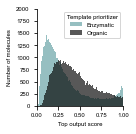

In [25]:
plt.figure()
plot_ind_distributions ([bkms_pred[np.multiply(moses_not_in_train_idxs, moses_not_in_historian),:], reaxys_pred[np.multiply(moses_not_in_train_idxs, moses_not_in_historian),:]], -1, 
                      figure_dir+'MOSES_score_comparison_traintestval.pdf',
                      bins = 100, colors = ['cadetblue', 'black'], 
                        labels = ['Enzymatic', 'Organic'], 
                        alpha = 0.65, edgecolor=None)

In [26]:
bkms_pred[np.multiply(moses_not_in_train_idxs, moses_not_in_historian),:].shape

(48869, 500)

[array([0.01418143, 0.0161873 , 0.01878862, 0.02232447, 0.02711723,
       0.03416632, 0.04502206, 0.06429037, 0.10593846, 0.32380956],
      dtype=float32), array([0.01115243, 0.0133273 , 0.01628617, 0.02039069, 0.02647638,
       0.03607812, 0.05268929, 0.08374566, 0.16531701, 0.44030938],
      dtype=float32)]


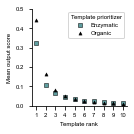

In [27]:
plot_scores ([bkms_pred[np.multiply(moses_not_in_train_idxs, moses_not_in_historian),-10:], reaxys_pred[np.multiply(moses_not_in_train_idxs, moses_not_in_historian),-10:]], 
             ['Enzymatic', 'Organic'], ['cadetblue', 'black'], 
             figure_dir+'top_10_mean_scores_moses_traintestval.pdf', markers = ['s', '^'], means = True, s=10, edgecolor='black', linewidth=0.5)

## Benchmark on ZINC Biogenic

In [28]:
try:
    biogenic_fps = [tf.constant(x) for x in np.load('9Apr2021_v4_zinc_biogenic_50k_fingerprints_all.npy')]
except:


    biogenic_fps = [tf.constant(np.array([smiles_to_fingerprint(smi)]), dtype=tf.float32) for smi in not_in_train]
    np.save('9Apr2021_v4_zinc_biogenic_50k_fingerprints_all', np.array([np.array(fp) for fp in biogenic_fps]))

In [29]:
try:    
    reaxys_pred_biogenic = np.load('reaxys_pred_biogenic_mols_no_train.npy')
except:
    reaxys_pred_biogenic = analyze_model(reaxys_path, biogenic_fps, trunc = 500)
    np.save('reaxys_pred_biogenic_mols_no_train', reaxys_pred_biogenic)
try:    
    bkms_pred_biogenic = np.load('{}_bkms_pred_biogenic_mols.npy'.format(DATE))
except:
    bkms_pred_biogenic = analyze_model(bkms_path, biogenic_fps, trunc = 500)
    np.save('{}_bkms_pred_biogenic_mols'.format(DATE), bkms_pred_biogenic)
    
print ('all_loaded')


all_loaded


In [37]:
try:
    zinc_in_train = np.load(DATE+'_zinc_in_bkms_train.npy')
    not_in_train = [smiles for smiles in std_biogenic if smiles not in zinc_in_train]
    print ('Loaded')
except:
    np.random.seed(111)
    biogenic = pd.read_csv('../../b-o-t/biogenic_2015.csv')
    rand_inds = np.random.choice(len(biogenic), 50000)
    biogenic = biogenic.loc[rand_inds, :]
    bkms_train = np.concatenate([np.load('../../template-relevance/data/processed/12May2021-bkmstrain.input.smiles.npy'),
                    np.load('../../template-relevance/data/processed/12May2021-bkmsvalid.input.smiles.npy'),
                    np.load('../../template-relevance/data/processed/12May2021-bkmstest.input.smiles.npy')])
    std_biogenic = standardize_smiles_list(biogenic['smiles'])
    std_bkms_train = standardize_smiles_list(bkms_train)
    not_in_train = [smiles for smiles in std_biogenic if smiles not in std_bkms_train]
    np.save(DATE+'_zinc_in_bkms_train.npy', np.array(list(std_bkms_train)))

try:
    zinc_in_historian = np.load(DATE+'_zinc_in_reaxys_train.npy')
    hashed_zinc = [hash_smiles(smiles) for smiles in not_in_train]
    zinc_not_in_historian = [h not in zinc_in_historian for h in tqdm(hashed_zinc)]
    print ('Loaded')
except:
    hashed_zinc = [hash_smiles(smiles) for smiles in not_in_train]
    print (len(hashed_zinc))
    reaxys_hashed_smiles_int = reaxys_products['smiles'].values
    zinc_in_historian = set(reaxys_hashed_smiles_int).intersection(hashed_zinc)
    zinc_not_in_historian = [h not in zinc_in_historian for h in tqdm(hashed_zinc)]
    np.save(DATE+'_zinc_in_reaxys_train.npy', np.array(list(zinc_in_historian)))

Loaded


100%|██████████| 49586/49586 [00:00<00:00, 117949.00it/s]

Loaded


In [ ]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in moses_subset['SMILES'].values[np.argsort(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1])[:50]]], legends = [str(x) for x in np.sort(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1])[:50] ])

In [ ]:
moses_subset['SMILES'].values[np.argsort(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1])[:50]]

In [ ]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in moses_subset['SMILES'].values[np.argsort(- reaxys_pred_biogenic[:, -1] + bkms_pred_biogenic[:, -1])[:50]]], legends = [str(x) for x in np.sort(- reaxys_pred_biogenic[:, -1] + bkms_pred_biogenic[:, -1])[:50] ])

In [ ]:
moses_subset['SMILES'].values[np.argsort(-reaxys_pred_biogenic[:, -1] + bkms_pred_biogenic[:, -1])[:50]]

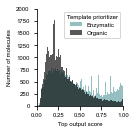

In [38]:
plot_ind_distributions ([bkms_pred_biogenic[zinc_not_in_historian, :], reaxys_pred_biogenic[zinc_not_in_historian, :]], -1, 
                      figure_dir+'ZINC_score_comparison_no_train.pdf',
                      bins = 100, colors = ['cadetblue', 'black'], 
                        labels = ['Enzymatic', 'Organic'], 
                        alpha = 0.65)

[array([0.01143971, 0.01326866, 0.01564363, 0.01901993, 0.02363009,
       0.03068355, 0.04268273, 0.06511971, 0.12234063, 0.4502207 ],
      dtype=float32), array([0.01585813, 0.01851   , 0.02174681, 0.02672339, 0.0328624 ,
       0.04208014, 0.05602099, 0.0806905 , 0.13901506, 0.32599017],
      dtype=float32)]


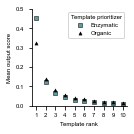

In [39]:
plot_scores ([bkms_pred_biogenic[zinc_not_in_historian,-10:], reaxys_pred_biogenic[zinc_not_in_historian,-10:]], 
             ['Enzymatic', 'Organic'], ['cadetblue', 'black'], 
             figure_dir+'top_10_mean_scores_biogenic_no_train.pdf', markers=['s', '^'], means = True, s=10, edgecolor='black', linewidth=0.5)

0.9555137
5943


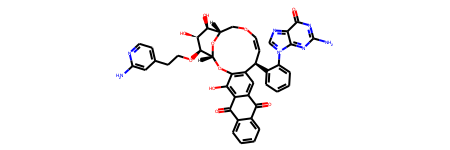

In [41]:
print (np.max(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1]))
print (np.argmax(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1]))
Chem.MolFromSmiles(not_in_train[np.argmax(reaxys_pred_biogenic[:, -1] - bkms_pred_biogenic[:, -1])])

In [ ]:
plot_comp(bkms_pred_biogenic[:,-10:], reaxys_pred_biogenic[:,-10:], 'bio_score', 'chem_score', 
        color = 'black',  label = 'Natural products', s=10, edgecolor='black', linewidth=0.5, marker = 's')
# fig, ax_arr = plt.subplots(1,1, figsize = (6,6))

# plot_comp(bkms_pred[:,-10:], reaxys_pred[:,-10:], 'bio_score', 'chem_score', 
#           color = 'darkgray',  label = 'Small organics', s=10, edgecolor='black', linewidth=0.5, marker = '^')
# plot_comp(bkms_pred[:,-10:], reaxys_pred[:,-10:], 'bio_score', 'chem_score', 
#           '../figures/top_10_fraction_chem_gt_bio_MOSES.png', color = 'navy', axs = ax_arr, label = 'BKMS > Reaxys')
# plt.grid()
plt.ylabel('Fraction of Molecules')
# plt.legend()

# ax_arr.grid()
# plt.legend(title='Input set', labelspacing=0.2, handletextpad=0.5, handlelength=1)#, bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.xticks(range(1,11))
plt.ylim((0.2,0.8))
plt.xlim((0.8,10.2))
plt.tight_layout(pad=0)
plt.savefig(figure_dir+'top_10_fraction_biogenic_no_train.pdf', dpi=300)

In [ ]:
plot_comp(bkms_pred[:,-10:], reaxys_pred[:,-10:], 'bio_score', 'chem_score', 
          color = 'black',  label = 'Small organics', s=10, edgecolor='black', linewidth=0.5, marker = 's')
# plot_comp(bkms_pred[:,-10:], reaxys_pred[:,-10:], 'bio_score', 'chem_score', 
#           '../figures/top_10_fraction_chem_gt_bio_MOSES.png', color = 'navy', axs = ax_arr, label = 'BKMS > Reaxys')
# plt.grid()
plt.ylabel('Fraction of Molecules')
# plt.legend()

# ax_arr.grid()
# plt.legend(title='Input set', labelspacing=0.2, handletextpad=0.5, handlelength=1)#, bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.xticks(range(0,11))
plt.ylim((0.2,0.8))
plt.xlim((0.8,10.2))
plt.tight_layout(pad=0)
plt.savefig(figure_dir+'top_10_fraction_MOSES_no_train.pdf', dpi=300)

[0.319343551126481, 0.691685935869365, 0.8836071947451349, 0.9520145695635269, 0.9808467535656551, 0.9921627207432114, 0.9966645521700873, 0.9984857476109599, 0.9991405594548691, 0.9995907425975568, 0.9998158341689005, 0.9999181485195113, 0.9999386113896335, 0.9999386113896335, 0.9999590742597556, 0.9999795371298777, 0.9999999999999999]
[0.68065645 0.95974953 0.99236735 0.99828112 0.99961121 0.9998363
 0.99995907 0.99997954 1.         0.        ]


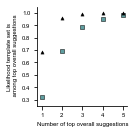

In [54]:
keep_idxs = np.multiply(moses_not_in_train_idxs, moses_not_in_historian)
plot_comp_2(reaxys_pred[keep_idxs,:], bkms_pred[keep_idxs,:], 'bio_score', 'chem_score', 
          color = 'cadetblue',  label = 'Small organics',  cumulative=True, s=10, edgecolor='black', linewidth=0.5, marker = 's')

plot_comp_2(bkms_pred[keep_idxs,:], reaxys_pred[keep_idxs,:], 'bio_score', 'chem_score', 
          color = 'black',  label = 'Small organics', cumulative=True, s=10, edgecolor='black', linewidth=0.5, marker = '^')

plt.ylabel('Likelihood template set is\n among top overall suggestions')
plt.xlabel('Number of top overall suggestions')
# plt.legend()

# ax_arr.grid()
# plt.legend(title='Input set', labelspacing=0.2, handletextpad=0.5, handlelength=1)#, bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.xticks(range(0,6))
plt.xlim((0.8,5.2))
plt.ylim(.25,1.05)
plt.tight_layout(pad=0.2)
plt.savefig(figure_dir+'overall_enzymatic_rank_MOSES_no_train.pdf', dpi=300)

[0.0, 0.6514354703390698, 0.8759745441895681, 0.9502956884732654, 0.9804579590333341, 0.9919990177822342, 0.9966236264298431, 0.9984652847408378, 0.9991405594548692, 0.9995907425975569, 0.9998158341689006, 0.9999181485195114, 0.9999386113896336, 0.9999386113896336, 0.9999590742597557, 0.9999795371298779, 1.0]


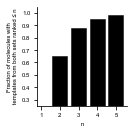

In [194]:
keep_idxs = np.multiply(moses_not_in_train_idxs, moses_not_in_historian)
plot_comp_3(reaxys_pred[keep_idxs,:], bkms_pred[keep_idxs,:], 'bio_score', 'chem_score', 
          color = 'black',  label = 'Small organics', edgecolor='black', linewidth=0.5)

plt.ylabel('Fraction of molecules with \n templates from both sets ranked ≤ n')
plt.xlabel('n')
# plt.legend()

# ax_arr.grid()
# plt.legend(title='Input set', labelspacing=0.2, handletextpad=0.5, handlelength=1)#, bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.xticks(range(0,6))
plt.xlim((0.8,5.6))
plt.ylim(.25,1.05)
plt.tight_layout(pad=0.2)
plt.savefig(figure_dir+'rank_of_both_MOSES_no_train.pdf', dpi=300)

[0.0, 0.7176862440324192, 0.9149772399245031, 0.9699344953924725, 0.9895636726990118, 0.9958032641279004, 0.9980903741534362, 0.9991340068835349, 0.9995114910625068, 0.9997335405795491, 0.9999111801931829, 0.9999777950482956, 0.9999999999999999]


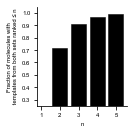

In [195]:
keep_idxs = zinc_not_in_historian
plot_comp_3(reaxys_pred_biogenic[keep_idxs,:], bkms_pred_biogenic[keep_idxs,:], 'bio_score', 'chem_score', 
          color = 'black',  label = 'Small organics', edgecolor='black', linewidth=0.5)

plt.ylabel('Fraction of molecules with \n templates from both sets ranked ≤ n')
plt.xlabel('n')
# plt.legend()

# ax_arr.grid()
# plt.legend(title='Input set', labelspacing=0.2, handletextpad=0.5, handlelength=1)#, bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.xticks(range(0,6))
plt.xlim((0.8,5.6))
plt.ylim(.25,1.05)
plt.tight_layout(pad=0.2)
plt.savefig(figure_dir+'rank_of_both_ZINC_no_train.pdf', dpi=300)

In [176]:
arr_1 = reaxys_pred[keep_idxs,:]
arr_2 = bkms_pred[keep_idxs,:]
comp_1 =  arr_1.shape[1]-np.sum((arr_1 < arr_2[:, -1][:, None]), axis=1)
comp_2 =  arr_2.shape[1]-np.sum((arr_2 < arr_1[:, -1][:, None]), axis=1)
comp = np.bincount(np.max(np.stack([comp_1, comp_2]), axis=0)) / arr_1.shape[0]


# comp = comp_1 / 2 + comp_2 / 2

comp = [sum(comp[:i+1]) for i in range(len(comp))]

In [177]:
comp

[0.0,
 0.6514354703390698,
 0.8759745441895681,
 0.9502956884732654,
 0.9804579590333341,
 0.9919990177822342,
 0.9966236264298431,
 0.9984652847408378,
 0.9991405594548692,
 0.9995907425975569,
 0.9998158341689006,
 0.9999181485195114,
 0.9999386113896336,
 0.9999386113896336,
 0.9999590742597557,
 0.9999795371298779,
 1.0]

[0.6425446874653048, 0.8855112690129899, 0.9627622959920062, 0.9864549794604197, 0.9948262462529145, 0.9977795048295771, 0.9989341623181971, 0.9995559009659155, 0.9997113356278451, 0.9997779504829578, 0.9999111801931831, 0.9999777950482959, 1.0]
[0.35745531253469526, 0.8321749750194294, 0.952214943932497, 0.9834795159320529, 0.9947374264460975, 0.9980237592983235, 0.9991562118352393, 0.9995781059176196, 0.9998001554346619, 0.9999555900965915, 1.0]


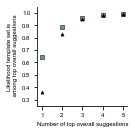

In [55]:
plot_comp_2(reaxys_pred_biogenic[zinc_not_in_historian, :], bkms_pred_biogenic[zinc_not_in_historian, :], 'bio_score', 'chem_score', 
          color = 'cadetblue',  label = 'Natural Products',  cumulative=True, s=10, edgecolor='black', linewidth=0.5, marker = 's')

plot_comp_2(bkms_pred_biogenic[zinc_not_in_historian, :], reaxys_pred_biogenic[zinc_not_in_historian, :], 'bio_score', 'chem_score', 
          color = 'black',  label = 'Natural Products', cumulative=True, s=10, edgecolor='black', linewidth=0.5, marker = '^')
plt.ylabel('Likelihood template set is\n among top overall suggestions')
plt.xlabel('Number of top overall suggestions')
plt.xticks(range(0,6))
plt.xlim((0.8,5.2))
plt.ylim(.25,1.05)
plt.tight_layout(pad=0.2)
plt.savefig(figure_dir+'overall_enzymatic_rank_biogenic_no_train.pdf', dpi=300)

In [228]:
bkms_pred_biogenic[zinc_not_in_historian, :].shape

(45035, 500)

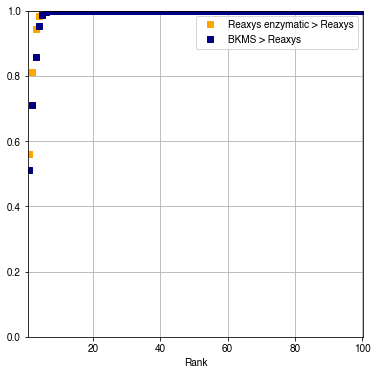

In [55]:
fig, ax_arr = plt.subplots(1,1, figsize = (6,6))
plot_comp(np.sqrt(bioreaxys_pred_biogenic)[:,-100:], reaxys_pred_biogenic[:,-100:], 'bio_score', 'chem_score', 
          '', color = 'orange', axs = ax_arr, label = 'Reaxys enzymatic > Reaxys')
plot_comp(np.sqrt(bkms_pred_biogenic)[:,-100:], reaxys_pred_biogenic[:,-100:], 'bio_score', 'chem_score', 
          '', color = 'navy', axs = ax_arr, label = 'BKMS > Reaxys')
ax_arr.grid()
plt.legend()
# ax_arr.set_ylim((0,0.6))
plt.savefig('../figures/scaled_top_10_fraction_biogenic_zinc,bkms_gt_reaxys_BKMS.png')

## Compare molecule sets

In [18]:
std_moses = standardize_smiles_list(moses['SMILES'])

KeyboardInterrupt: 

In [38]:
std_moses = standardize_smiles_list(moses_subset['SMILES'])

In [39]:
same = [s in std_biogenic for s in std_moses]

In [40]:
np.sum(same)

14

In [41]:
bkms_hist = pd.read_json('temprel/data/processed/historian.bio.json.gz')
# bio_train = np.load('temprel/data/processed/bioreaxys-ss-train.input.smiles.npy')
# bkms_train = np.load('../../rotation/template-relevance/data/processed/train.input.smiles.npy')


std_bkms_hist = standardize_smiles_list(bkms_hist['smiles'])
std_bio_train = standardize_smiles_list(bio_train)
std_bkms_train = standardize_smiles_list(bkms_train)

bkms_not_in_bkms_train = [smiles for smiles in std_bkms_hist if smiles not in std_bkms_train]
bkms_not_in_train = [smiles for smiles in bkms_not_in_bkms_train if smiles not in std_bio_train]

In [42]:
same_bkms_biogenic = [s in std_biogenic for s in bkms_not_in_train]

In [43]:
np.sum(same_bkms_biogenic)

113

In [52]:
bioreaxys_pred_biogenic.shape

(49624, 500)

In [48]:
old_model = tf.keras.models.load_model(bkms_path)
# new_model = tf.keras.models.load_model(bkms_simple)

OSError: SavedModel file does not exist at: ../for GCP/bkms_model_all_data/{saved_model.pbtxt|saved_model.pb}

In [ ]:
old_model.signatures['serving_default']

In [42]:
# new_model.signatures['serving_default']

In [9]:


fp = [tf.constant(np.array([smiles_to_fingerprint(smi)]), dtype=tf.float32) for smi in ['Brc1ccc2[nH]c3c(c2c1)CCNC3']]
# fp_2 = [tf.constant(np.array([smiles_to_fingerprint(smi)]), dtype=tf.float32) for smi in ['CC1=CC2C(C(C)C)CC[C@@H](C)C2CC1']]

In [10]:
test = analyze_model(bkms_path, fp)
# test_2 = analyze_model(bkms_path, fp_2)

In [11]:
srted = np.argsort(test)[0]
len(srted) - list(srted).index(2596)

1841

In [12]:
ind = 2596
print ([c[ind] for c in test])
# print (test_2[0][ind])

[4.836346e-06]


In [13]:
np.sum(fp[0] - fp_2[0])/(fp[0].shape[1])

NameError: name 'fp_2' is not defined

In [14]:
test[0][1709]

5.0243534e-06

In [16]:
np.sort(test)[0][-28:]

array([0.00397586, 0.00415141, 0.00496486, 0.00510496, 0.00534576,
       0.005384  , 0.00543819, 0.00567776, 0.00624628, 0.00660864,
       0.00731874, 0.00810805, 0.00825084, 0.00921426, 0.00929689,
       0.01007634, 0.01141179, 0.01351032, 0.014783  , 0.01602425,
       0.01618598, 0.01624606, 0.01671474, 0.02417267, 0.03832597,
       0.04245573, 0.14063703, 0.37531203], dtype=float32)

In [38]:
np.argsort(test)[0][-28:]

array([6981, 6787, 5398, 1629, 7656, 6511, 7480, 4463, 7455, 3049, 4799,
        325, 4813, 3255, 3326, 1762, 1554, 5405, 1489, 5044, 7461,  290,
       3053, 2498, 6562, 1234, 3048, 1292])

In [45]:
len(np.argsort(test)[0])

7185

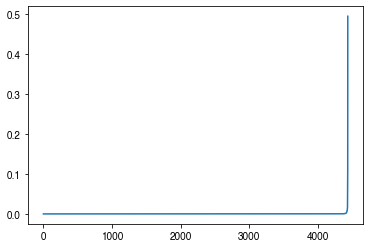

In [311]:
plt.plot(np.sort(tf.nn.softmax(test[0]).numpy()))

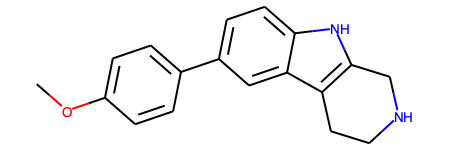

In [179]:
Chem.MolFromSmiles('COC(C=C1)=CC=C1C2=CC=C(NC3=C4CCNC3)C4=C2')

In [24]:
bkms_pred

array([[2.35147263e-06, 2.37090126e-06, 2.37343033e-06, ...,
        1.02664538e-01, 3.74567360e-01, 3.94566208e-01],
       [8.31235957e-05, 8.45184841e-05, 8.52050944e-05, ...,
        3.52688730e-02, 1.16041213e-01, 3.50733757e-01],
       [3.85003441e-05, 3.91458125e-05, 3.91905633e-05, ...,
        7.45484680e-02, 9.82382074e-02, 1.54129282e-01],
       ...,
       [3.13789587e-06, 3.15636589e-06, 3.17308036e-06, ...,
        5.09215482e-02, 7.93787464e-02, 7.15171516e-01],
       [1.82977001e-05, 1.83504744e-05, 1.84620803e-05, ...,
        9.12298262e-03, 2.25195792e-02, 8.13409209e-01],
       [4.95581980e-06, 5.01058503e-06, 5.08811218e-06, ...,
        1.24112815e-01, 1.30896121e-01, 2.39885971e-01]], dtype=float32)

In [40]:
np.argwhere ( reaxys_pred < bkms_pred[:, -1][:, None])

array([[    0,     0],
       [    0,     1],
       [    0,     2],
       ...,
       [49999,   496],
       [49999,   497],
       [49999,   498]])

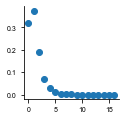

In [14]:
counts =  np.bincount(reaxys_pred.shape[1]-np.sum((reaxys_pred < bkms_pred[:, -1][:, None]), axis=1)) / reaxys_pred.shape[0]
plt.scatter(range(len(counts)), counts)

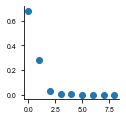

In [66]:
counts =  np.bincount(500-np.sum((bkms_pred < reaxys_pred[:, -1][:, None]), axis=1)) / 50000
plt.scatter(range(len(counts)), counts)

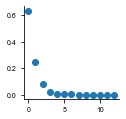

In [65]:
counts =  np.bincount(500-np.sum((reaxys_pred_biogenic < bkms_pred_biogenic[:, -1][:, None]), axis=1))/50000
plt.scatter(range(len(counts)), counts)

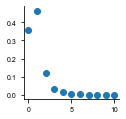

In [67]:
counts =  np.bincount(500-np.sum((bkms_pred_biogenic < reaxys_pred_biogenic[:, -1][:, None]), axis=1))/50000
plt.scatter(range(len(counts)), counts)

## Evaluate how "confidence" correlates with correctness

In [6]:
!ls ../for\ GCP/

12Apr2021_v4
12May2021-bkms
12May2021-bkms.zip
13May2021-retro.templates.combined.json.gz
15Jun2021_bkms_traintestval
19Feb2020.retro.templates.combined.json.gz
22Mar2021_retro.templates.combined.json.gz
24May2021_bkms
24May2021_bkms.zip
25May2021_retro.templates.combined.json.gz
29Jun2021-retro.templates.combined.json.gz
29Jun2021_bkms_traintestval
29Jun2021_bkms_traintestval.zip
29Mar2021_reaxys_enzymatic
29Mar2021_reaxys_enzymatic.zip
30Mar2021_bkms.zip
30Mar2021_reaxys_enzymatic
30Mar2021_reaxys_enzymatic.zip
31Mar2021_bkms_neutral.zip
31Mar2021_retro.templates.combined.json.gz
5Apr2021_retro.templates.combined.json.gz
8Apr2021-bkms.zip
8Apr2021_retro.templates.combined.json.gz
9Apr2021-bkms
9Apr2021-bkms.zip
9Apr2021_v4-bkms
9Apr2021_v4-bkms.zip
9Apr2021_v4_retro.templates.combined.json.gz
9Jun2021_bkms_traintestval
9Jun2021_bkms_traintestval.zip
bkms.zip
bkms_model_all_data
bkms_model_all_data.zip
buyables.combined.json.gz


In [21]:
bkms_model = '../for GCP/12May2021-bkms'
test_x = np.load('../data/processed/12May2021-bkmstest.input.smiles.npy')
test_y = np.load('../data/processed/12May2021-bkmstest.labels.classes.npy')

In [22]:
test_fps = [tf.constant(np.array([smiles_to_fingerprint(smi)]), dtype=tf.float32) for smi in test_x]

  4%|▍         | 422/11002 [00:20<03:34, 49.24it/s]

In [23]:
pred_scores = analyze_model(bkms_model, test_fps)


 66%|██████▌   | 1711/2592 [00:34<00:16, 51.83it/s]


100%|██████████| 2592/2592 [00:51<00:00, 50.08it/s]


In [45]:
argsorted_pred_scores = np.argsort(pred_scores, axis=1)
top_score = np.sort(pred_scores, axis=1)

In [41]:
correct = [y_pred==y for y_pred,y in zip(argsorted_pred_scores[:,-1], test_y)] 

In [42]:
sum(correct)/len(correct)

0.1878858024691358

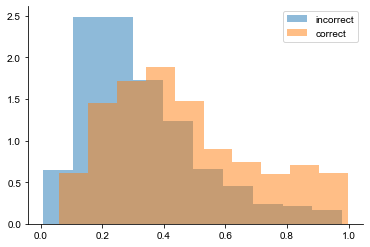

In [77]:
plt.hist(top_score[[not x for x in correct], -1], label = 'incorrect', alpha = 0.5, density=True)
plt.hist(top_score[correct, -1], label = 'correct', alpha = 0.5, density=True)
plt.legend()

Text(0, 0.5, 'Top-1 prediction score')

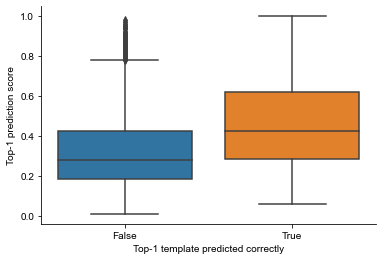

In [86]:
b = sns.boxplot(correct, top_score[:,-1])
b.set_xlabel('Top-1 template predicted correctly')
b.set_ylabel('Top-1 prediction score')

In [62]:
scipy.stats.ttest_ind(top_score[correct, -1], top_score[[not x for x in correct], -1])

Ttest_indResult(statistic=13.817704816520573, pvalue=5.914837911745464e-42)

In [79]:
scipy.stats.mannwhitneyu(top_score[correct, -1], top_score[[not x for x in correct], -1])

MannwhitneyuResult(statistic=325452.5, pvalue=1.503991866228796e-36)

In [51]:
np.mean(top_score[correct, -1])

0.46533322

In [57]:
np.mean(top_score[[not x for x in correct], -1])

0.32673144

In [88]:
bkms_pred_biogenic.shape

(49586, 500)